## Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("monthly_csv.csv")

## Data Exploratory

In [3]:
data.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
data.shape

(847, 2)

In [5]:
data.describe()

,Price
count,847.000000
mean,416.556906
std,453.665313
min,34.490000
25%,35.190000
50%,319.622000
75%,447.029000
max,1840.807000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    847 non-null    object 
 1   Price   847 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.4+ KB


**Since the date is object, we have to convert it a proper datetime.**

## Data Preprocessing

In [7]:
# Find the first and last dates
print("Date ranges from", data.iloc[1,0], "to", data.iloc[-1,0])

# Another way
first_date = data["Date"].min()
last_date = data["Date"].max()

print("First date:", first_date)
print("Last date:", last_date)

Date ranges from 1950-02 to 2020-07
First date: 1950-01
Last date: 2020-07


In [8]:
# Conver date
data["NewDate"] = pd.to_datetime(data["Date"])

In [9]:
data.head()

,Date,Price,NewDate
0,1950-01,34.73,1950-01-01
1,1950-02,34.73,1950-02-01
2,1950-03,34.73,1950-03-01
3,1950-04,34.73,1950-04-01
4,1950-05,34.73,1950-05-01


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     847 non-null    object        
 1   Price    847 non-null    float64       
 2   NewDate  847 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 20.0+ KB


In [11]:
# Let's drop the Date of object type then
data.drop("Date", axis =1, inplace = True)

In [12]:
# Rename Date column
data.rename(columns = {"NewDate" : "Date"}, inplace = True)

In [13]:
# Remove indexing
data.set_index("Date", inplace = True)

In [14]:
# Re-check
data.head()

,Price
Date,
1950-01-01,34.73
1950-02-01,34.73
1950-03-01,34.73
1950-04-01,34.73
1950-05-01,34.73


## Data Visualization 

<Axes: xlabel='Date'>

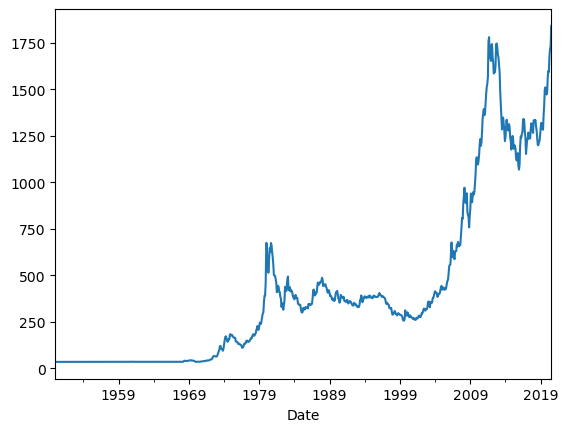

In [15]:
data["Price"].plot()

Text(0, 0.5, 'Price')

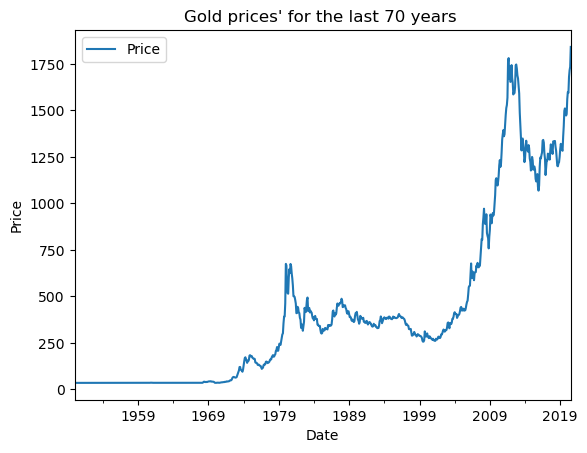

In [16]:
data[["Price"]].plot()
plt.title("Gold prices' for the last 70 years ")
plt.ylabel("Price")

There seems to be a significant increase in gold prices over the past 70 years.

Text(0, 0.5, 'Price')

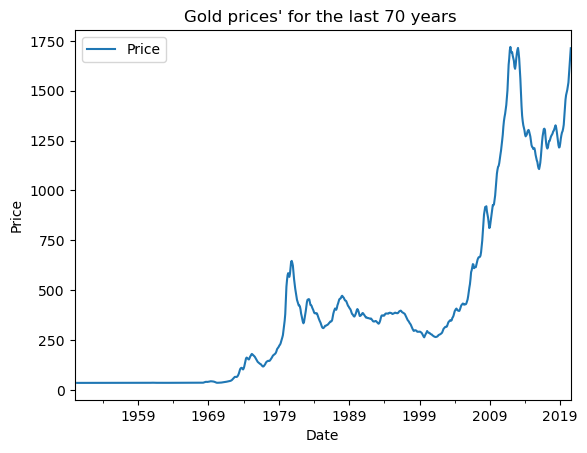

In [17]:
# Smoothing the above graph
data[["Price"]].rolling(5).mean().plot()
plt.title("Gold prices' for the last 70 years ")
plt.ylabel("Price")

<Axes: xlabel='Date', ylabel='Price'>

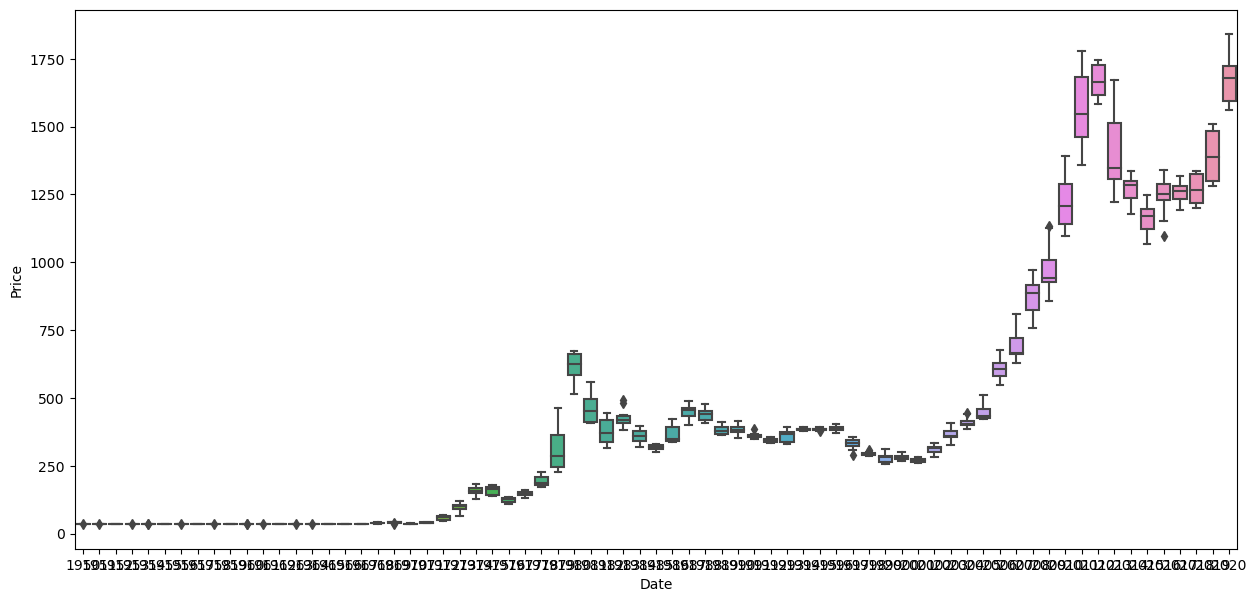

In [18]:
_,ax = plt.subplots(figsize=(15,7))
sns.boxplot(x = data.index.year, y = data.Price)

Years with wider boxes have a larger spread of prices, which means prices were more volatile in those years

## Decomposing the Time Series

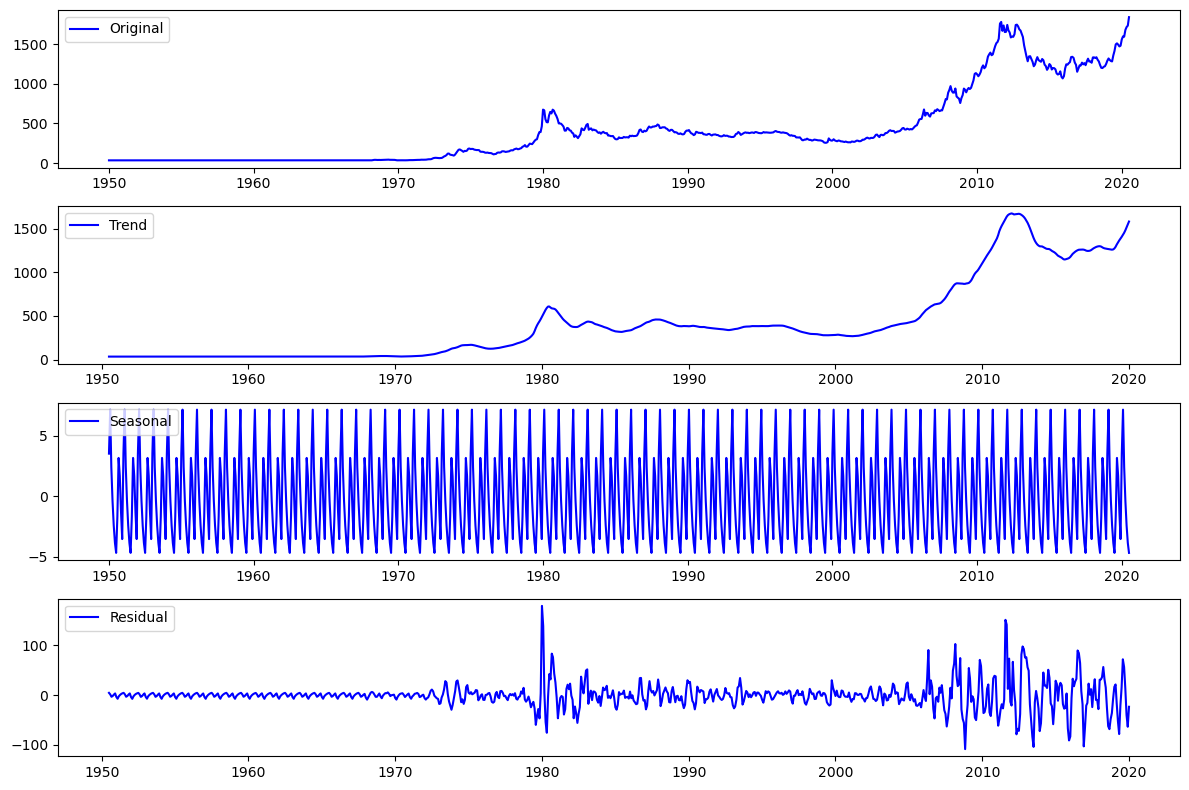

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(data['Price'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['Price'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='blue')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Testing for Stationarity

In [40]:
from statsmodels.tsa.stattools import adfuller

# Test for stationarity using the Augmented Dickey-Fuller test
result = adfuller(data['Price'])

In [41]:
result

(0.8143240077835291,
 0.9918639010465631,
 11,
 835,
 {'1%': -3.4382057088878644,
  '5%': -2.865007578546518,
  '10%': -2.5686164240381513},
 7602.766734758613)

While the number of lags, number of observations, and residual sum of squares provide additional information about the ADF regression, they are not typically crucial for interpreting the stationarity test results. Therefore, they are often omitted from the printed output for simplicity.

In [42]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.8143240077835291
p-value: 0.9918639010465631
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


### Based on these results:

#### The ADF statistic is positive, suggesting non-stationarity.
#### The high p-value indicates weak evidence against the null hypothesis of non-stationarity.
#### The ADF statistic is greater than the critical values, further supporting the non-stationarity of the time series.
#### Therefore, we fail to reject the null hypothesis, indicating that the time series is likely non-stationary. This suggests that further steps, such as differencing, may be necessary to make the time series stationary before modeling.

### **While stationarity is not always necessary for every analysis or application, it often simplifies the modeling process, improves forecast accuracy, and facilitates better interpretation of results. Therefore, in many cases, achieving stationarity in a time series is indeed desirable.**

In [44]:
# Difference the data to achieve stationarity
diff_1 = data['Price'].diff().dropna()

Differencing a time series involves computing the difference between consecutive observations. In other words, it's a way of transforming the data to make it more stationary.

In [46]:
# Conducting Another ADF Test on differenced data
result_diff = adfuller(diff_1)
print('ADF Statistic (Differenced Data):', result_diff[0])
print('p-value (Differenced Data):', result_diff[1])
print('Critical Values (Differenced Data):')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic (Differenced Data): -6.2170869264073465
p-value (Differenced Data): 5.3332825133419275e-08
Critical Values (Differenced Data):
	1%: -3.438
	5%: -2.865
	10%: -2.569


**We can see that differencing the data has successfully made it stationary.**

## Modeling

In [49]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")

The order parameter specifies the p, d, and q parameters of the ARIMA model, where:

p is the number of autoregressive (AR) terms.

d is the degree of differencing.

q is the number of moving average (MA) terms.

In [50]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model to the differenced data
model = ARIMA(data['Price'], order=(1,1,1))  
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  847
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3894.605
Date:                Fri, 22 Mar 2024   AIC                           7795.209
Time:                        17:27:04   BIC                           7809.431
Sample:                    01-01-1950   HQIC                          7800.658
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5398      0.042    -12.838      0.000      -0.622      -0.457
ma.L1          0.7664      0.031     24.425      0.000       0.705       0.828
sigma2       583.4947     10.859     53.736      0.0

Overall, based on these results, we can conclude that the ARIMA(1, 1, 1) model provides a reasonably good fit to the stationary time series data. The coefficients are statistically significant, and diagnostic tests do not indicate any major issues with the model. However, it's essential to further evaluate the model's performance through validation and forecasting before making any final conclusions.

### Forecasting with ARIMA

In [51]:
forecast_steps = 12 # for the next 12 months
forecast = model_fit.forecast(steps=forecast_steps)

print("Forecasted Values:")
print(forecast)

Forecasted Values:
2020-08-01    1857.333553
2020-09-01    1848.411821
2020-10-01    1853.228149
2020-11-01    1850.628091
2020-12-01    1852.031713
2021-01-01    1851.273979
2021-02-01    1851.683035
2021-03-01    1851.462209
2021-04-01    1851.581421
2021-05-01    1851.517065
2021-06-01    1851.551807
2021-07-01    1851.533052
Freq: MS, Name: predicted_mean, dtype: float64


**Now, you can evaluate the model's accuracy if you have the actual values for these 12 months.**